# Exercise 4: Single scattering properties in Mie and Rayleight regimes  


This execise is about the comparison between the scattering properties in MW of various Hydrometeors (cloud and precipitaiton particles) comparing the results form the Mie and Rayleigh regime.

The student is asked to answer some questions after completing the notebook.

The student is asked to write the functions for calculating the rayleigh scattering properties.




If miepython is not installed, uncomment the following cell (i.e., delete the #) and run (shift-enter)

In [7]:
!pip install miepython

In [4]:
import numpy as np
import matplotlib.pyplot as plt

try:
    import miepython

except ModuleNotFoundError:
    print('miepython not installed. To install, uncomment and run the cell above.')
    print('Once installation is successful, rerun this cell again.')

miepython not installed. To install, uncomment and run the cell above.
Once installation is successful, rerun this cell again.


In [1]:
import miepython

## Rayleigh Scattering Functions

In [2]:
def rayleigh(m,x):
    """
    Calculate the efficiencies for a small sphere.
            
    Based on equations 5.7 - 5.9 in Bohren and Huffman

    Args:
        m: the complex index of refraction of the sphere
        x: the size parameter of the sphere

    Returns:
        qext: the total extinction efficiency
        qsca: the scattering efficiency
        qback: the backscatter efficiency
        g: the average cosine of the scattering phase function
    """
    ratio = (m**2-1)/(m**2+2)
    qsca = 8/3*x**4*abs(ratio)**2
    qext = 4*x*ratio*(1+x**2/15*ratio*(m**4+27*m**2+38)/(2*m**2+3))
    qext = abs(qext.imag + qsca)
    qback = 4*x**4*abs(ratio)**2
    g = 0
    return qext, qsca, qback, g


def rayleigh_S1_S2(m,x,mu):
    """
    Calculate the scattering amplitude functions for small spheres.

    Based on equation 5.4 in Bohren and Huffman

    The amplitude functions are normalized so that when integrated
    over all 4*pi solid angles, the integral will be qext*pi*x**2.

    The units are weird, sr**(-0.5)

    Args:
        m: the complex index of refraction of the sphere
        x: the size parameter of the sphere
        mu: the angles, cos(theta), to calculate scattering amplitudes

    Returns:
        S1, S2: the scattering amplitudes at each angle mu [sr**(-0.5)]
    """

    a1 = (2*x**3)/3 * (m**2-1)/(m**2+2)*1j
    a1 += (2*x**5)/5 * (m**2-2)*(m**2-1)/(m**2+2)**2 *1j

    s1 = (3/2)*a1*np.ones_like(mu)
    s2 = (3/2)*a1*mu
    
    ## scale so integral over all angles is single scattering albedo
    qext, qsca, qback, g = rayleigh(m,x)

    factor = np.sqrt(np.pi*qext)*x
    return s1/factor, s2/factor


def rayleigh_unpolarized(m,x,mu):
    """
    Return the unpolarized scattered intensity for small spheres.

    This is the average value for randomly polarized incident light.
    The intensity is normalized so the integral of the unpolarized 
    intensity over 4pi steradians is equal to the single scattering albedo.

    Args:
       m: the complex index of refraction of the sphere
       x: the size parameter
       mu: the cos(theta) of each direction desired

    Returns
       The intensity at each angle in the array mu.  Units [1/sr]
    """
    s1, s2 = rayleigh_S1_S2(m,x,mu)
    return (abs(s1)**2+abs(s2)**2)/2

## Compare Mie and Rayleigh

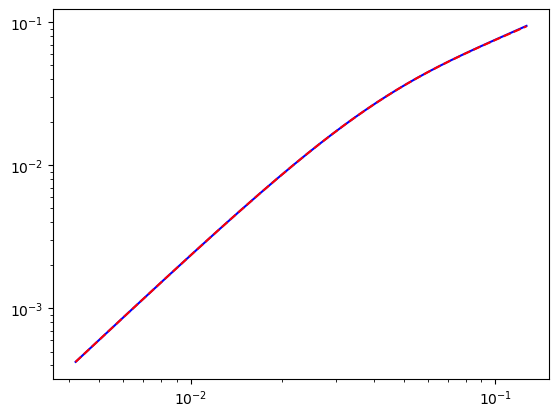

In [21]:
from refraction import complex_n_water_liebe93
import numpy as np

freq=np.linspace(10,302,302)  #in GHz 2-302
t=283.
n = complex_n_water_liebe93(freq,t)
part_radius = 20e-6  # radius size in m it is 20 micron
c =  299792458 #speed of light in vauum in m / s
wavelenght = c/(freq*1e9)
x =2*np.pi*part_radius / wavelenght



mieext=np.zeros((np.shape(x)))
miesca=np.zeros((np.shape(x)))
miebak=np.zeros((np.shape(x)))
mieg=np.zeros((np.shape(x)))

rayext=np.zeros((np.shape(x)))
raysca=np.zeros((np.shape(x)))
raybak=np.zeros((np.shape(x)))
rayg=np.zeros((np.shape(x)))

for iv in range(len(x)):
    n1=n[iv,0]-1j*np.abs(n[iv,1])
    x1=x[iv]
    mieext[iv],miesca[iv],miebak[iv],mieg[iv]=miepython.mie(n1,x1)  

    rayext[iv],raysca[iv],raybak[iv],rayg[iv]=rayleigh(n1,x1)
    
    
import matplotlib.pyplot as plt
plt.plot(x,mieext,'b')
plt.plot(x,rayext,'--r')
plt.yscale('log')
plt.xscale('log')


In [1]:
import numpy as np
def calc_tau0(ka,Z,i0,i1):
    #calculates the nadir optical depth integrating ka*dZ between two levels i0 and i1
    # ka absroption coefficient in Np/m
    # Z height in m
    # i0,i1 the two extreme levels for integration
    if i0<=i1:
        tau0=np.trapz(ka[i0:i1],Z[i0:i1])
    else:
        tau0=np.trapz(ka[i1:i0],Z[i1:i0])
    return tau0
def calc_gamma(ka,Z,i0,i1,UMU):
    #calculates the trasmissivity
    # ka absroption coefficient in Np/m
    # Z height in m
    # i0,i1 the two levels for integration
    # UMU is cosine of the observation angle
    tau0=calc_tau0(ka,Z,i0,i1)
    gamma=np.exp(-1*tau0/UMU)
    return gamma

def calc_weighting_function(ka,Z,i,UMU,updir):
    #calculates the trasmissivity
    # ka absroption coefficient in Np/m
    # Z height in m
    # i the level of the weighting function
    # UMU is cosine of the observation angle
    # updir indicates if the weighting function
    #       is for radiaiton moving upward (updir=1)
    #       or downward (updir=0)
    if updir==1:
        gamma=calc_gamma(ka,Z,i,len(Z),UMU)
    else:
        gamma=calc_gamma(ka,Z,i,0,UMU)
    wf=ka[i]*gamma/UMU
    return wf
def calc_TB_DN(ka,Z,T,UMU):
    # calculates the brightness temperaure emitted by the atmosphere and directed downward
    # ka absroption coefficient in Np/m
    # Z height in m
    # T is the temperature in K
    # UMU is cosine of the observation angle
    
    wf=np.zeros(np.shape(Z))
    for i in range(0,len(Z)):
        wf[i]=calc_weighting_function(ka,Z,i,UMU,updir=0)
    T_DN=np.trapz(wf*T,Z)
    return T_DN

def calc_TB_UP(ka,Z,T,UMU):
    # calculates the brightness temperaure emitted by the atmosphere and directed upward
    # ka absroption coefficient in Np/m
    # Z height in m
    # T is the temperature in K
    # UMU is cosine of the observation angle
    wf=np.zeros(np.shape(Z))
    for i in range(0,len(Z)):
        wf[i]=calc_weighting_function(ka,Z,i,UMU,updir=1)
    T_UP=np.trapz(wf*T,Z)
    return T_UP

def plot_WF(wf1,Z):
    import matplotlib.pyplot as plt
    n=np.shape(wf1)[1]
    
    color = iter(plt.cm.rainbow(np.linspace(0, 1, n)))   
    for iv in range(n):
        col=next(color)
        plt.plot(wf1[:,iv]*1000, Z/1000,c=col,label = "ch "+str(iv+1))
    plt.ylim(0,60)
    plt.legend()    
    
    plt.xlabel('Weighting Functions 1/km')
    plt.ylabel('Height km')
    plt.show()

in the next cell the WF at 55.5 GHz with vaious weighting functions is plotted



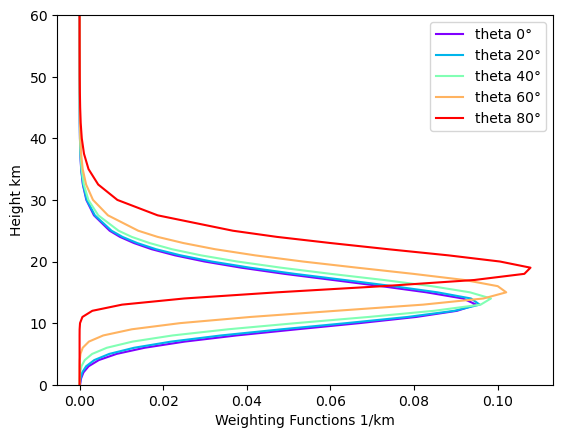

In [2]:
def plot_WF(wf1,Z,lbl):
    import matplotlib.pyplot as plt
    n=np.shape(wf1)[1]
    
    color = iter(plt.cm.rainbow(np.linspace(0, 1, n)))   
    for iv in range(n):
        col=next(color)
        plt.plot(wf1[:,iv]*1000, Z/1000,c=col,label = lbl[iv])
    plt.ylim(0,60)
    plt.legend()    
    
    plt.xlabel('Weighting Functions 1/km')
    plt.ylabel('Height km')
    plt.show()

from load_atm_prf import *
from gas_attenuation_rose98 import *
#profile_file_name='afgl_1986-subarctic_winter.nc'

profile_file_name='./afgl_1986-midlatitude_summer.nc'
# profile_file_name='afgl_1986-tropical.nc'

Z,P,T,RH=load_atm__prf(profile_file_name)
T_surf=T[0]+0  # Surface temperature is taken as equal to the temperature of last layer
T[10]=T[10]+0

Z=Z*1000 # height from km to m

emis=0.7
# frequencies from the satellite radiometer ATMS channels 1-16 
# see https://space.oscar.wmo.int/instruments/view/atms
Frequencies=[  55.5, ]
Obs_angles=[0, 20, 40, 60, 80] # in degrees




#---------------end of settings section ----------------------------------

TB=np.zeros(np.shape(Obs_angles))
wf1=np.zeros((len(Z),len(Obs_angles)))
lbl=[]    
for itheta in range(len(Obs_angles)):
    Obs_angle=Obs_angles[itheta]
    UMU = np.abs(np.cos(Obs_angle*np.pi/180.)  ) # cosine of the Obseration Angle

    T_COS=2.7  # cosmic background radiation temperature
    T_GAL=0.   # Radiation from the galaxy is approximated  to  0
    T_SUN=0.   # Radiation from Sun  approximated  to  0

    T_EXTRA=T_COS + T_GAL + T_SUN




    
    F=Frequencies[0]
    ka=gas_abs(P, T, RH, F)

    gamma = calc_gamma(ka, Z, len(Z), 0,       UMU)

    T_DN = calc_TB_DN(ka,Z,T,UMU)             # TB emitted by the atmosphere downward

    T_SS = (T_EXTRA*gamma + T_DN) *(1-emis) # TB reflected from the surface

    T_SE = emis*T_surf                        # TB emitted from the surface


    T_UP=calc_TB_UP(ka,Z,T,UMU)              # TB emitted by the atmosphere upward

    TB[itheta]=  (T_SS+T_SE)*gamma  + T_UP
    lbl.append('theta ' + str(Obs_angle) +'°')
    for i in range(0,len(Z)):
        wf1[i,itheta]=calc_weighting_function(ka,Z,i,UMU,updir=1)
plot_WF(wf1,Z,lbl)


The Weighting Function Does Change with the observation angle!! At Nadir it peaks (meaning that the higher value of the curve is placed) at lower heights than when observing at 80°. This is a consequence of the sec( $\theta$ ) factor in the clear sky radiative transfer equation.

Now let's move to another set of channesl, we are plotting the Weighting Functions for the Water vapor absorption band at 183 GHz. 



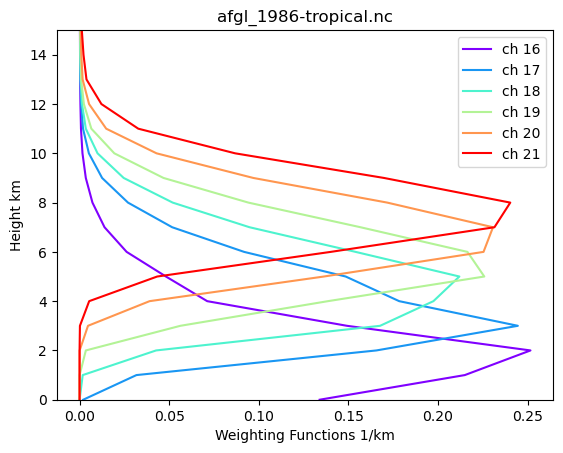

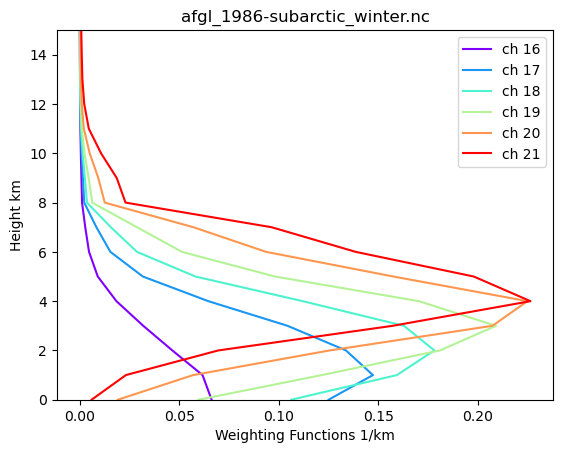

In [8]:
def plot_WF(wf1,Z,lbl,title):
    import matplotlib.pyplot as plt
    n=np.shape(wf1)[1]
    
    color = iter(plt.cm.rainbow(np.linspace(0, 1, n)))   
    for iv in range(n):
        col=next(color)
        plt.plot(wf1[:,iv]*1000, Z/1000,c=col,label = lbl[iv])
    plt.ylim(0,15)
    plt.legend()    
    
    plt.xlabel('Weighting Functions 1/km')
    plt.ylabel('Height km')
    plt.title(title)
    plt.show()
    
    
from load_atm_prf import *
from gas_attenuation_rose98 import *


# profile_file_name='afgl_1986-subarctic_winter.nc'
profile_file_name='afgl_1986-midlatitude_summer.nc'
#profile_file_name='afgl_1986-tropical.nc'
for profile_file_name in ['afgl_1986-tropical.nc','afgl_1986-subarctic_winter.nc']:

    Z,P,T,RH=load_atm__prf(profile_file_name)
    T_surf=T[0]+0  # Surface temperature is taken as equal to the temperature of last layer
    T[10]=T[10]+0

    Z=Z*1000 # height from km to m

    emis=0.7

    Obs_angle=0 # in degrees

    # frequencies from the satellite radiometer ATMS channels 1-16 
    # see https://space.oscar.wmo.int/instruments/view/atms
    Frequencies=[165.6, 
                183.31+7, 
                183.31+4.5, 
                183.31+3, 
                183.31+1.8, 
                183.31+1, 
              ]


    #---------------end of settings section ----------------------------------
    lbl=[]
    UMU = np.abs(np.cos(Obs_angle*np.pi/180.)  ) # cosine of the Obseration Angle

    T_COS=2.7  # cosmic background radiation temperature
    T_GAL=0.   # Radiation from the galaxy is approximated  to  0
    T_SUN=0.   # Radiation from Sun  approximated  to  0

    T_EXTRA=T_COS + T_GAL + T_SUN

    TB=np.zeros(np.shape(Frequencies))
    wf1=np.zeros((len(Z),len(Frequencies)))


    for iv in range(len(Frequencies)):
        F=Frequencies[iv]
        ka=gas_abs(P, T, RH, F)

        gamma = calc_gamma(ka, Z, len(Z), 0,       UMU)

        T_DN = calc_TB_DN(ka,Z,T,UMU)             # TB emitted by the atmosphere downward

        T_SS = (T_EXTRA*gamma + T_DN) *(1-emis) # TB reflected from the surface

        T_SE = emis*T_surf                        # TB emitted from the surface


        T_UP=calc_TB_UP(ka,Z,T,UMU)              # TB emitted by the atmosphere upward

        TB[iv]=  (T_SS+T_SE)*gamma  + T_UP
        lbl.append('ch ' +str(iv+16))
        for i in range(0,len(Z)):
            wf1[i,iv]=calc_weighting_function(ka,Z,i,UMU,updir=1)
    plot_WF(wf1,Z,lbl,profile_file_name)




In this case the differences between two profiles are evident: the tropical profile is very hot and wet, while the subarctic winter profile is very cold and dry. Plese note that in the last case ch 21 Peack is on the Earth surface (the lower level) while the peack of the same channel in the tropical profile is at about 2 km.
